In [51]:
import os
from pprint import pprint
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel, mutual_info_classif, f_classif, SelectKBest
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

## Предобработка данных

In [2]:
acc = pd.read_csv('df_accounts_sample.csv', index_col=0).sort_values(by=['inn', 'year'])
acc['bankrupt'] = 0
bkrpt = pd.read_csv('df_bankruptcies_sample.csv', index_col=0).sort_values(by=['inn', 'bancrupt_year'])

In [167]:
print(f"Кол-во компаний: {len(acc.groupby('inn'))}")

Кол-во компаний: 166


Распределение по кол-ву лет, которые работала компания

array([[<AxesSubplot:title={'center':'num_of_years'}>]], dtype=object)

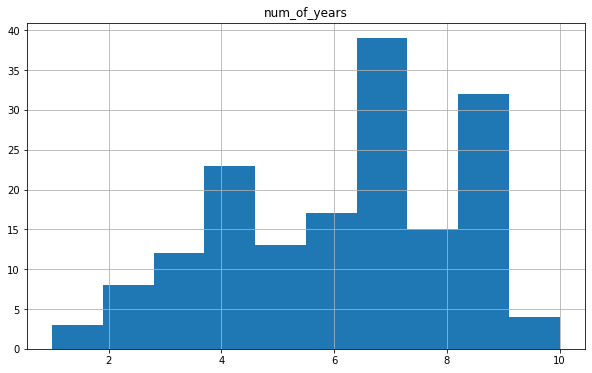

In [4]:
years = acc.groupby('inn')['year'].count().to_frame()
years.rename(columns={'year':'num_of_years'}, inplace=True)
years.hist(figsize=(10,6))

Расчитаем средние показатели по каждой компании

In [5]:
acc_agg = acc.groupby('inn').agg(
    avgLTL = pd.NamedAgg(column = 'long_term_liabilities_fiscal_year', aggfunc = 'mean'),
    avgSTL = pd.NamedAgg(column = 'short_term_liabilities_fiscal_year', aggfunc = 'mean'),
    avgAssets = pd.NamedAgg(column = 'balance_assets_fiscal_year', aggfunc = 'mean'),
)
acc_agg.reset_index(inplace=True)
acc_agg

,inn,avgLTL,avgSTL,avgAssets
0,1001003743,0.000000,2520.875000,5411.625000
1,1020010136,0.000000,28033.500000,11333.750000
2,1203000142,142806.000000,264435.250000,482090.500000
3,1302000640,2465.333333,14792.666667,28078.666667
4,1411004211,42454.333333,34764.166667,137146.500000
...,...,...,...,...
161,8617004112,0.000000,3333.750000,4419.000000
162,8901998318,0.000000,233.200000,279.600000
163,8908001998,0.000000,9317.777778,83812.888889
164,8909000186,10.500000,13456.500000,27238.750000


Добавим новые фичи:
- SL/A: Short Term Liabilities / Assets
- LL/A: Long Term Liabilities / Assets
- bankrupt - целевая переменная

In [6]:
acc_agg['SL/A'] = acc_agg.apply(lambda row: row.avgSTL/row.avgAssets, axis=1)
acc_agg['LL/A'] = acc_agg.apply(lambda row: row.avgLTL/row.avgAssets, axis=1)
acc_agg['bankrupt'] = 0
acc_agg.describe()

,inn,avgLTL,avgSTL,avgAssets,SL/A,LL/A,bankrupt
count,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,166.000000,166.000000,166.0
mean,5.131689e+09,7.933706e+04,9.765644e+04,1.959457e+05,1.211455,0.132026,0.0
std,2.176713e+09,6.514206e+05,3.308873e+05,8.085340e+05,2.666510,0.353237,0.0
min,1.001004e+09,0.000000e+00,0.000000e+00,6.666667e+00,0.000000,0.000000,0.0
25%,3.411299e+09,0.000000e+00,2.405488e+03,4.682869e+03,0.305258,0.000000,0.0
50%,5.410220e+09,0.000000e+00,9.694083e+03,2.025571e+04,0.644691,0.000000,0.0
75%,7.079508e+09,2.887938e+03,4.642927e+04,8.593272e+04,1.121068,0.076790,0.0
max,9.102060e+09,8.191701e+06,3.033256e+06,8.454400e+06,22.496451,2.897274,0.0


Обновим значения целевой переменнной

In [7]:
cnt = 0
for _, b_row in bkrpt.iterrows():
    for i, a_row in acc_agg.iterrows():
        if a_row['inn'] == b_row['inn']:
            acc_agg.at[i,'bankrupt'] = 1
            cnt += 1

Распределение компаний по столбцу bankrupt

In [8]:
acc_agg.groupby('bankrupt')['inn'].count()

bankrupt
0     60
1    106
Name: inn, dtype: int64

Выведем график распределения компаний по переменным LL/A и SL/A

C:\Users\Alexander\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


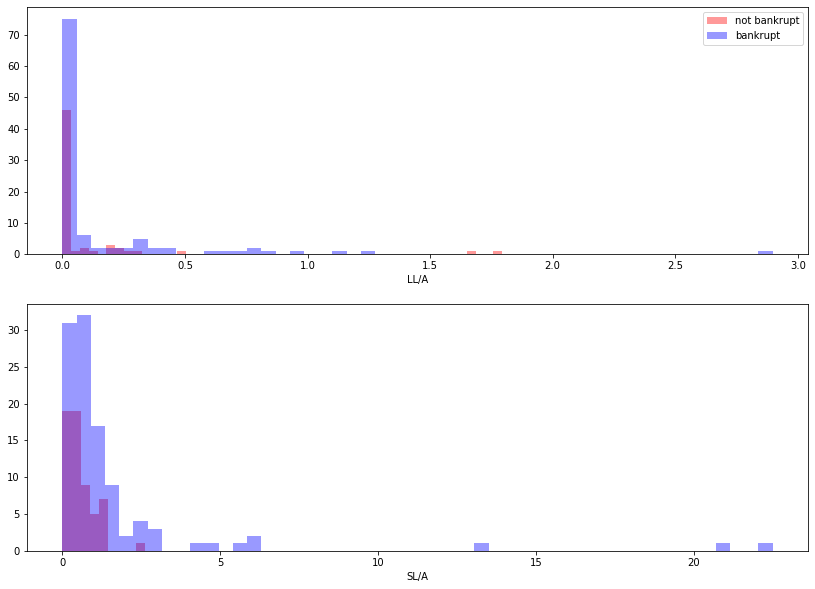

In [172]:
fig, ax = plt.subplots(2, figsize=(14,10))
for (name, group), c in zip(acc_agg.groupby('bankrupt'), ['r', 'b']):
    sns.distplot(group['LL/A'], ax=ax[0], kde=False, hist=True, color=c, label='bankrupt' if name else 'not bankrupt')
    ax[0].legend()
    sns.distplot(group['SL/A'], ax=ax[1], kde=False, hist=True, color=c, label=name)

Рассчитаем матрицу корреляции признаков

<AxesSubplot:>

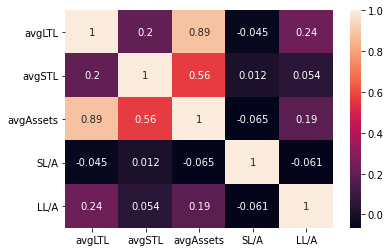

In [10]:
import seaborn as sns
%matplotlib inline

corr = acc_agg.drop(['inn', 'bankrupt'], axis=1).corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True)

Создадим новые фичи по судебным записям:
- num_cases_{0,1,2}: сколько раз компания учавствовала в суде в качестве {истца, ответчика, свидетеля}
- cases_lost: процент проигранных дел (в расчет не берутся дела с неопределенным результатом)

In [11]:
court_path = 'success/'
pkls = [f for f in os.listdir(court_path) if f.endswith('pkl')]
cols = ['inn', 'num_cases_0', 'num_cases_1', 'num_cases_2', 'cases_lost']
data = []
for f in pkls:
    d = pickle.load(open(court_path + f, 'rb'))
    inn = d['inn']
    sides = defaultdict(int)
    cases = []
    
    for case in d['cases_list']:
            
        for side in case['case_sides']:
            if side['INN'] == str(inn):
                sides[side['type']] += 1
                if side['type'] in (0, 1):
                    if case['resultType'] != 'Не удалось определить':
                        cases.append(case['resultType']) 
                        
    cases_lost = list(filter(lambda x: x in ('Проиграно', 'Частично проиграно', 'Не выиграно'), cases))
    data.append([inn, sides[0], sides[1], sides[2], len(cases_lost)/len(cases) if len(cases) > 0 else 0.0])
    
#     print(f"INN: {inn} | {[sides[0], sides[1], sides[2], len(cases_lost)/len(cases) if len(cases) > 0 else 0.0]}")
#     print(cases_lost)     
#     print(sides)
#     pprint(cases)

In [12]:
cases = pd.DataFrame(data, columns=cols)
cases

,inn,num_cases_0,num_cases_1,num_cases_2,cases_lost
0,1001003743,4,0,0,0.000000
1,1001227084,0,0,0,0.000000
2,1020010136,13,68,5,0.694444
3,1203000142,197,207,31,0.572414
4,1214002504,0,0,0,0.000000
...,...,...,...,...,...
188,8617004112,0,27,1,0.920000
189,8901998318,0,1,0,0.000000
190,8908001998,9,20,7,0.500000
191,8909000186,1,29,0,0.937500


Объеденим датасеты по ИНН компании

C:\Users\Alexander\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


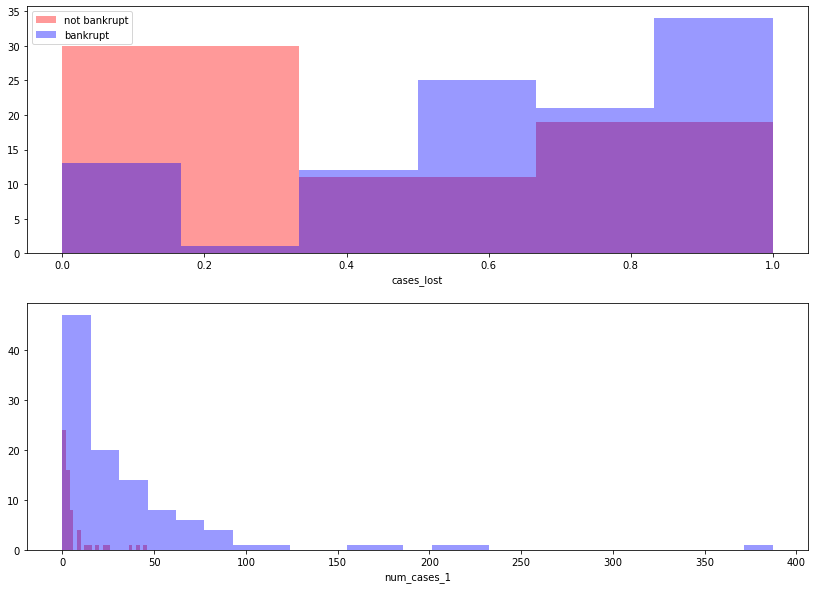

In [13]:
acc_merged = pd.merge(acc_agg, cases, how='left', on='inn')
fig, ax = plt.subplots(2, figsize=(14,10))
for (name, group), c in zip(acc_merged.groupby('bankrupt'), ['r', 'b']):
    sns.distplot(group['cases_lost'], ax=ax[0], kde=False, hist=True, color=c, label='bankrupt' if name else 'not bankrupt')
    ax[0].legend()
    sns.distplot(group['num_cases_1'], ax=ax[1], kde=False, hist=True, color=c, label=name)

## Создание датасета

In [133]:
y = acc_merged['bankrupt']
X = acc_merged.drop(['bankrupt', 'inn'], axis=1)
X

,avgLTL,avgSTL,avgAssets,SL/A,LL/A,num_cases_0,num_cases_1,num_cases_2,cases_lost
0,0.000000,2520.875000,5411.625000,0.465826,0.000000,4,0,0,0.000000
1,0.000000,28033.500000,11333.750000,2.473453,0.000000,13,68,5,0.694444
2,142806.000000,264435.250000,482090.500000,0.548518,0.296222,197,207,31,0.572414
3,2465.333333,14792.666667,28078.666667,0.526829,0.087801,3,6,0,1.000000
4,42454.333333,34764.166667,137146.500000,0.253482,0.309555,2,15,3,0.923077
...,...,...,...,...,...,...,...,...,...
161,0.000000,3333.750000,4419.000000,0.754413,0.000000,0,27,1,0.920000
162,0.000000,233.200000,279.600000,0.834049,0.000000,0,1,0,0.000000
163,0.000000,9317.777778,83812.888889,0.111174,0.000000,9,20,7,0.500000
164,10.500000,13456.500000,27238.750000,0.494020,0.000385,1,29,0,0.937500


Разделим датасет на train/test (для теста оставим 10% данных)

In [148]:
X_raw,X_test,y_raw,y_test  = train_test_split(X,
                                              y,
                                              test_size=0.1,
                                              stratify = y)
X_raw

,SL/A,LL/A,num_cases_0,num_cases_1,num_cases_2,cases_lost
69,1.285121,0.059938,9,36,6,0.818182
26,0.753591,0.000000,61,62,9,0.581395
131,0.644236,0.347247,13,10,0,1.000000
60,2.603160,0.000000,0,36,2,0.700000
156,0.901454,0.000000,15,42,2,0.685714
...,...,...,...,...,...,...
56,0.044600,0.000000,4,1,0,0.000000
113,0.931534,0.000000,1,84,0,0.983871
16,0.532247,0.047458,0,8,1,0.333333
158,0.052005,0.013459,11,10,2,0.421053


Разделим данные для кроссвалидации (используем 5 фолдов)

In [149]:
sss = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for train_index, test_index in sss.split(X_raw,y_raw):
    
    print("Train:", train_index, "\nTest:", test_index, "\n")
    X_train_sm, X_val_sm = X_raw.iloc[train_index], X_raw.iloc[test_index]
    y_train_sm, y_val_sm = y_raw.iloc[train_index], y_raw.iloc[test_index]

X_train_sm = X_train_sm.values
X_val_sm = X_val_sm.values
y_train_sm = y_train_sm.values
y_val_sm = y_val_sm.values

train_unique_label, train_counts_label = np.unique(y_train_sm, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_val_sm, return_counts=True)
print('-' * 84)

print('Label Distributions: \n')
print(train_counts_label/ len(y_train_sm))
print(test_counts_label/ len(y_val_sm))

Train: [  0   1   2   3   4   6   7   9  10  12  13  14  15  16  21  23  24  25
  26  27  29  30  31  32  33  34  35  36  37  39  40  41  42  43  44  46
  49  50  51  52  53  54  55  56  58  59  60  62  63  64  65  66  67  68
  69  70  71  72  73  75  79  80  81  83  84  85  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 105 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 122 123 125 126 128 129 130 131 132 133
 134 135 136 137 139 140 142 144 145 147 148] 
Test: [  5   8  11  17  18  19  20  22  28  38  45  47  48  57  61  74  76  77
  78  82  86 104 106 121 124 127 138 141 143 146] 

Train: [  0   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  22  24  25  27  28  31  32  33  35  38  40  41  43  44  45  46  47
  48  49  50  51  52  54  57  58  59  61  62  63  65  66  68  70  72  73
  74  76  77  78  79  80  81  82  83  84  85  86  87  88  89  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 

## Тренировка и валидация моделей
Функции для удобной тренировки моделей и вывода AUC кривой

In [156]:
def val_model(model, params):
    accuracy= []
    precision = []
    recall = []
    f1 = []
    auc = []

    param_cv = RandomizedSearchCV(model, params, n_iter=4)

    for train, val in sss.split(X_train_sm, y_train_sm):
        pipeline = make_pipeline(SMOTE(sampling_strategy='minority'), param_cv)

        model_ = pipeline.fit(X_train_sm[train], y_train_sm[train])
        best_est_ = param_cv.best_estimator_
        prediction_ = best_est_.predict(X_train_sm[val])

        accuracy.append(pipeline.score(X_train_sm[val], y_train_sm[val]))
        precision.append(precision_score(y_train_sm[val], prediction_))
        recall.append(recall_score(y_train_sm[val], prediction_))
        f1.append(f1_score(y_train_sm[val], prediction_))
        auc.append(roc_auc_score(y_train_sm[val], prediction_))
        
        auc_vals = roc_curve(y_train_sm[val], prediction_)
    
    print(model)
    print(f"accuracy: {np.mean(accuracy)}")
    print(f"precision: {np.mean(precision)}")
    print(f"recall: {np.mean(recall)}")
    print(f"f1: {np.mean(f1)}")
    print(f"roc-auc: {np.mean(auc)}")
    
    label = ['Not bankrupt', 'Bankrupt']
    pred = best_est_.predict(X_val_sm)
    print(classification_report(y_val_sm, pred, target_names=label))
    
    sns.heatmap(confusion_matrix(y_val_sm, pred), annot=True)


    
    return np.mean(auc), auc_vals, best_est_

def plot_roc(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

#### RandomForestClassifier

RandomForestClassifier()
accuracy: 0.775
precision: 0.8034451985922573
recall: 0.8400000000000001
f1: 0.8195486581729468
roc-auc: 0.7505555555555556
              precision    recall  f1-score   support

Not bankrupt       0.43      0.30      0.35        10
    Bankrupt       0.68      0.79      0.73        19

    accuracy                           0.62        29
   macro avg       0.56      0.54      0.54        29
weighted avg       0.59      0.62      0.60        29



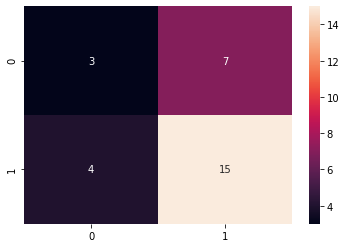

In [157]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

params = {'max_features' : ['auto', 'sqrt', 'log2'],
              'random_state' : [42],
              'class_weight' : ['balanced','balanced_subsample'],
              'criterion' : ['gini', 'entropy'],
              'bootstrap' : [True,False]}
model = RandomForestClassifier()
roc_auc, (fpr, tpr, threshold), rfc = val_model(model, params)

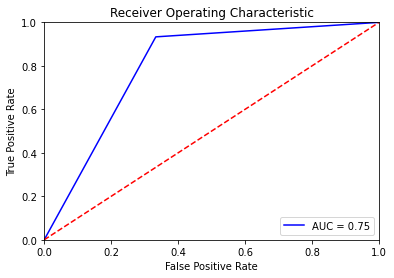

In [158]:
plot_roc(fpr, tpr, roc_auc)

#### XGB

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)
accuracy: 0.75
precision: 0.8032993966817497
recall: 0.7866666666666667
f1: 0.7921814147620599
roc-auc: 0.7363888888888889
              precision    recall  f1-score   support

Not bankrupt       0.33      0.30      0.32        10
    Bankrupt       0.65      0.68      0.67        19

    accuracy                           0.55 

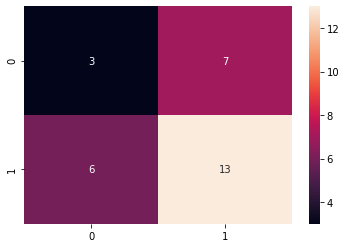

In [173]:
params = {'eta' : [0.1,0.01,0.001], 
              'eval_metric': ['logloss'],
              'max_depth' : [3,6,9],
              'lambda' : [1,1.5,2],      
              'alpha' : [0,0.5,1]} 
model = xgb.XGBClassifier(random_state = 42, use_label_encoder=False)

roc_auc, (fpr, tpr, threshold), xgbc = val_model(model, params)

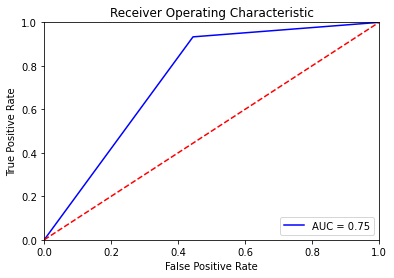

In [160]:
plot_roc(fpr, tpr, roc_auc)

#### CatBoostClassifier

accuracy: 0.825
precision: 0.8645726495726496
recall: 0.8533333333333333
f1: 0.8564995030270174
roc-auc: 0.812777777777778
              precision    recall  f1-score   support

Not bankrupt       0.56      0.50      0.53        10
    Bankrupt       0.75      0.79      0.77        19

    accuracy                           0.69        29
   macro avg       0.65      0.64      0.65        29
weighted avg       0.68      0.69      0.69        29



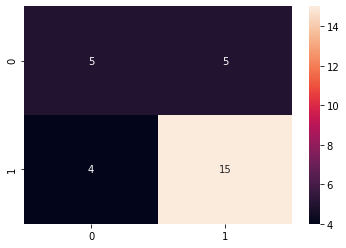

In [161]:
params = {'eval_metric': ['F1'],
              'iterations': [100,500,1000],
              'learning_rate' : [0.1,0.01,0.001],
              'random_seed' : [42],
              'auto_class_weights' : ['Balanced','SqrtBalanced']
             }
model = CatBoostClassifier(verbose = 0)
roc_auc, (fpr, tpr, threshold), cbc = val_model(model, params)

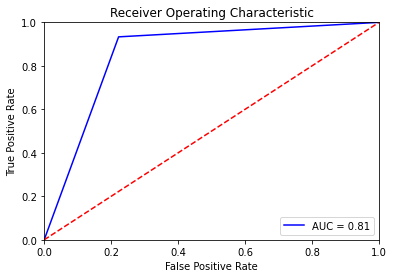

In [162]:
plot_roc(fpr, tpr, roc_auc)

## Проверка моделей на тестовых данных

In [165]:
test_pred_rf = rfc.predict(X_test.values)
test_pred_xgb = xgbc.predict(X_test.values) 
test_pred_cat = cbc.predict(X_test.values)

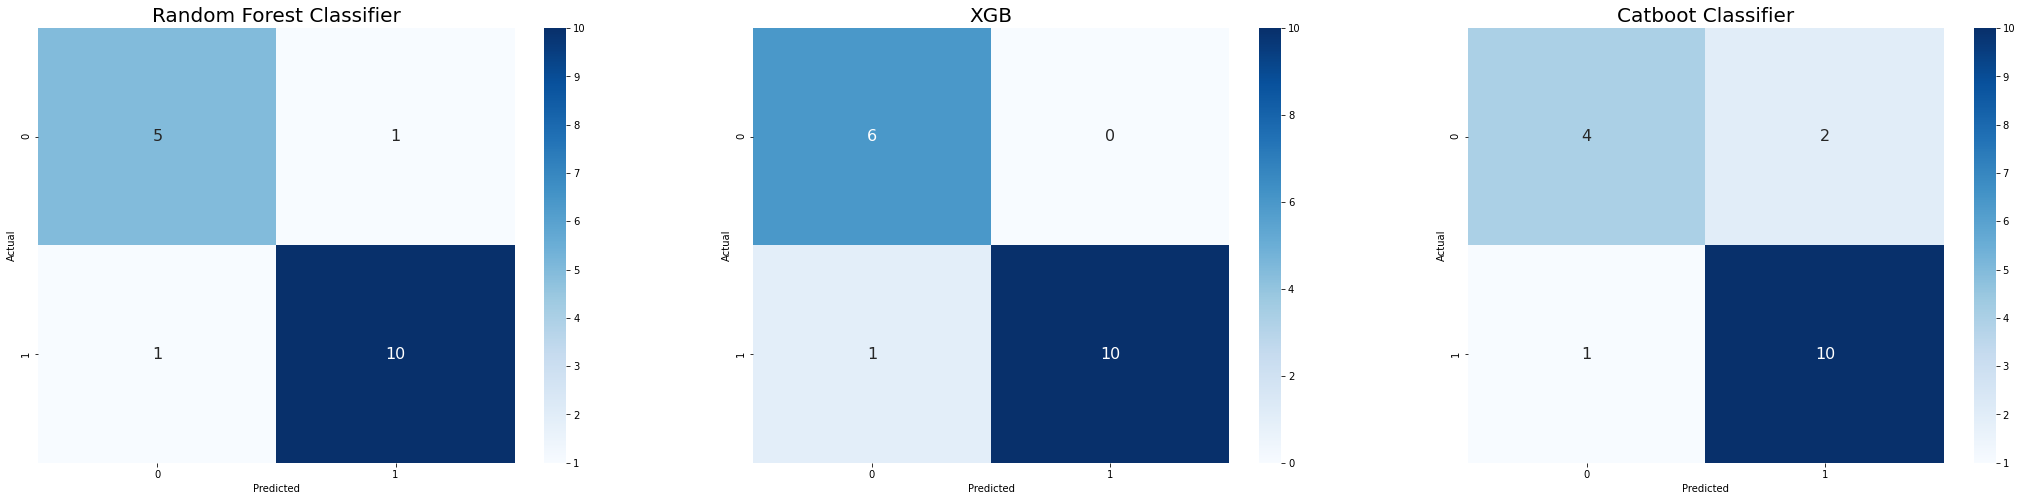

In [164]:
conf_mx0 = confusion_matrix(y_test,test_pred_rf)
conf_mx1 = confusion_matrix(y_test,test_pred_xgb)
conf_mx2 = confusion_matrix(y_test,test_pred_cat)

heat_cm0 = pd.DataFrame(conf_mx0, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm0.index.name = 'Actual'
heat_cm0.columns.name = 'Predicted'

heat_cm1 = pd.DataFrame(conf_mx1, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm1.index.name = 'Actual'
heat_cm1.columns.name = 'Predicted'

heat_cm2 = pd.DataFrame(conf_mx2, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm2.index.name = 'Actual'
heat_cm2.columns.name = 'Predicted'

f, ax = plt.subplots(1, 3, figsize=(15,8))
f.subplots_adjust(left=None, bottom=None, right= 2, top=None, wspace=None, hspace= None)

sns.heatmap(heat_cm0, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[0])
ax[0].set_title('Random Forest Classifier', fontsize = 20)
sns.heatmap(heat_cm1, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[1])
ax[1].set_title('XGB', fontsize = 20)
sns.heatmap(heat_cm2, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[2])
ax[2].set_title('Catboot Classifier', fontsize = 20)

plt.show()

In [166]:
print(classification_report(y_test, test_pred_rf, target_names=['0', '1']))
print(classification_report(y_test, test_pred_xgb, target_names=['0', '1']))
print(classification_report(y_test, test_pred_cat, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.91      0.91      0.91        11

    accuracy                           0.88        17
   macro avg       0.87      0.87      0.87        17
weighted avg       0.88      0.88      0.88        17

              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.91      0.95        11

    accuracy                           0.94        17
   macro avg       0.93      0.95      0.94        17
weighted avg       0.95      0.94      0.94        17

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.83      0.91      0.87        11

    accuracy                           0.82        17
   macro avg       0.82      0.79      0.80        17
weighted avg       0.82      0.82      0.82        17



## Вывод
Можно заметить, что все 3 выбранных классификатора показывают хорошие результаты на тестовой выборке. Лучший F1-score у модели XGB. Однако для того чтобы более уверенно говорить о производительности моделей, необходимо тестировать их на большей выборке.